## Kernel ridge regression under power-law data:  spectrum and generalization

In this notebook, we're going to explore a bit how the power-law structure of the training set can influence the spectral properties of the kernel operator.

First, let us define a simple (dot-product) kernel:
$$
K(x,x') = \langle x,x' \rangle
$$
Ideally, we'd like to compute the spectrum for the kernel operator:
$$
Tf = \int dx' p(x') K(x,x') f(x') = \mathbb{E}[K(x,x')f(x')]_{x' \sim p }
$$
Numerically, we can proceed as follows. Imagine we sample from $p(x)$ and obtain a set of IID values $\{x_1, x_2, x_3, \dots, x_M\}$. We can approximate the distribution $p(x)$ as:
$$
p(x) \approx  \frac{1}{M}  \sum_i^M  \delta(x'-x_i) 
$$
Hence:
$$
(Tf) (x) \approx \frac{1}{M}  \sum_i^M \int dx' \delta(x'-x_i) K(x,x') f(x') =  \sum_i^M\frac{1}{M} K(x,x_i)f(x_i)
$$
The eigenfunctions $g_k(x)$ with eigenvalue $\lambda_k$ is such that, $\forall x_i$:
$$
(Tg_k)(x_j)
$$
Combining:
$$
(Tg_k)(x)  = \lambda_k g_k(x) \approx \sum_i^M\frac{1}{M} K(x,x_i)g_k(x_i)
$$
If I let $\vec v = (g_k(x_1), g_k(x_2), \dots)$, then:
$$
\lambda_k v_j = \frac{1}{M} \sum_i K(x_k, x_i) v_i
$$
in vectorial form:
$$
\lambda_k \vec v = \frac{1}{M} K \vec v
$$
hence I can estimate the eigenvalues $\lambda_k$ of the operator once I have built the empirical matrix $K(x_i, x_j)$, provided $x_i \sim p(x)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# A simple kernel, for now (dot-product, linear)
def linear_kernel_matrix(X):
    return X @ X.T

def empiricalDiagonalization(M, kernelFunction, covarianceMatrix):
    # Sample points from the distribution (M of them). We assume a normal multivariate distribution here
    dim = covarianceMatrix.shape[0]
    samples = np.random.multivariate_normal(mean=np.zeros(dim), cov=covarianceMatrix, size=M)
    # Compute the kernel matrix
    K = kernelFunction(samples)
    # Eigen-decomposition of the kernel matrix
    eigenvalues, eigenvectors = np.linalg.eigh(K)
    # Sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    return eigenvalues / M

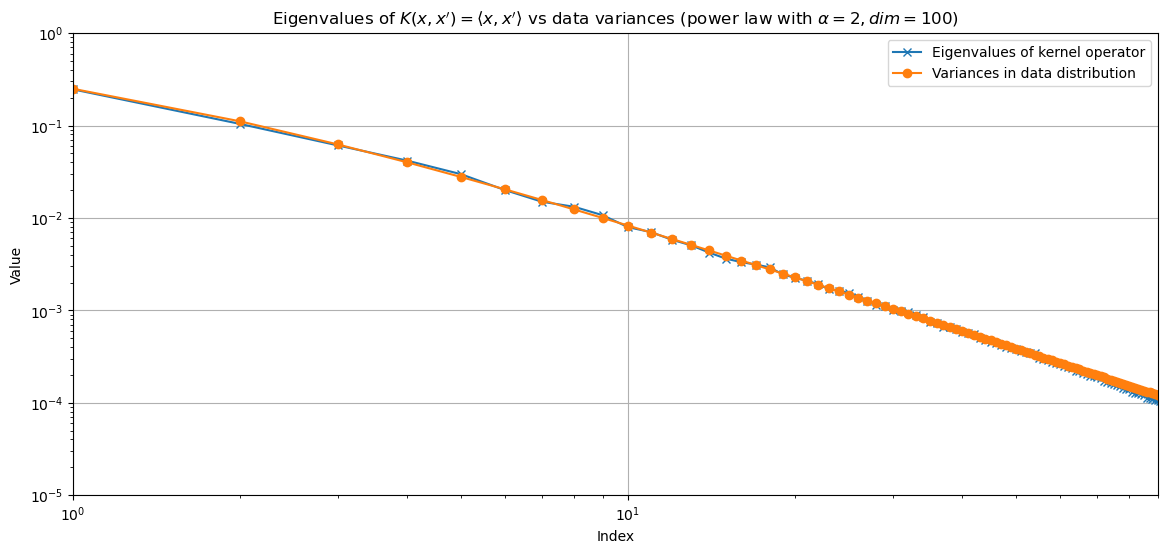

In [2]:
# let's test it
d = 100
alpha = 2

# a power law covariance matrix
Sigma = np.array([i**(-alpha) for i in range(1, d+1)])
eigen = empiricalDiagonalization(1000, linear_kernel_matrix, np.diag(Sigma))

plt.figure(figsize=(14,6))
plt.loglog(eigen, label='Eigenvalues of kernel operator', marker='x')
plt.loglog(Sigma, label='Variances in data distribution', marker='o')
plt.xlabel('Index')
plt.ylabel('Value')
plt.xlim(1, d-10)
plt.ylim(1e-5, 1e0)
plt.title(fr"Eigenvalues of $K(x,x') = \langle x,x' \rangle$ vs data variances (power law with $\alpha={alpha}, dim = {d}$)")
plt.legend()
plt.grid(True)
plt.show()

For a simple linear dot-product kernel, the match is convincing. Let's try with far more complex kernels and see what happens

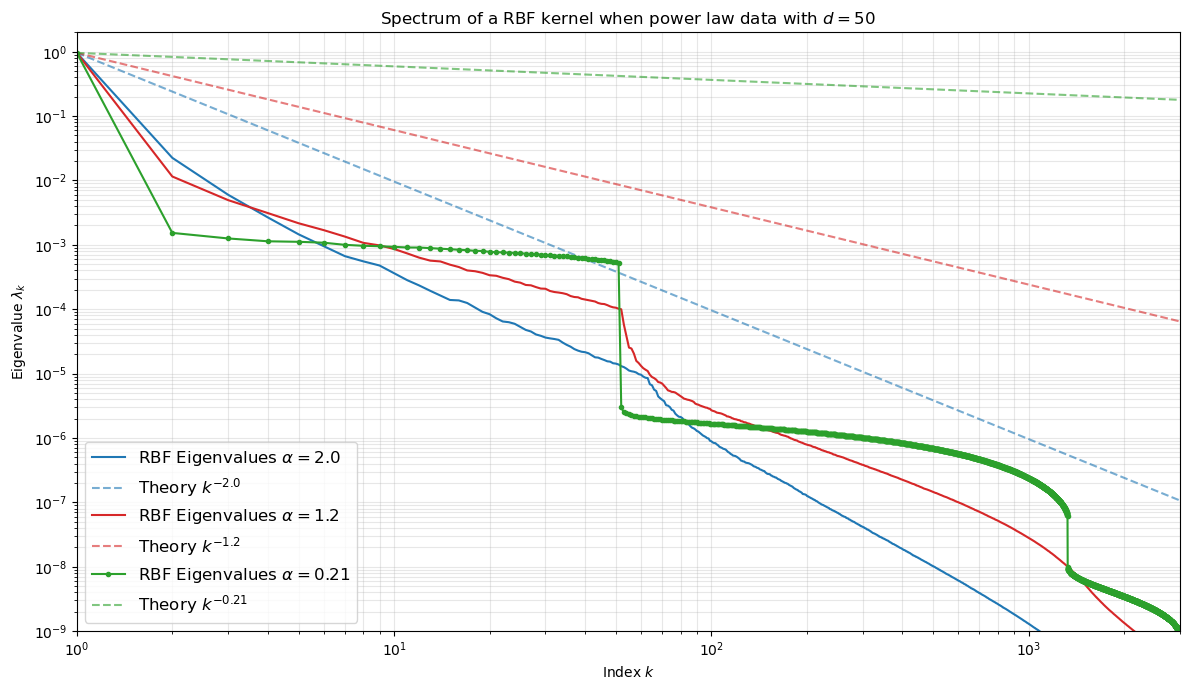

In [7]:

# --- PARAMETRI FISSI ---
d = 50
M = 3000
alphas = [2.0, 1.2, 0.21] # Lista degli alpha da testare


def rbf_kernel_matrix(X, gamma=1 / d):
    # Calcolo ottimizzato distanze
    sq_norms = np.sum(X**2, axis=1)
    dist_sq = sq_norms[:, None] + sq_norms[None, :] - 2 * np.dot(X, X.T)
    dist_sq = np.maximum(dist_sq, 0.0)
    K = np.exp(-gamma * dist_sq)
    return K

plt.figure(figsize=(12, 7), dpi=100)

colors = ['#1f77b4', '#d62728', '#2ca02c'] # Blu, Rosso e Verde

for i, alpha in enumerate(alphas):
    # 1. Generazione Sigma
    Sigma_vals = np.array([k**(-alpha) for k in range(1, d+1)])
    Sigma_vals = Sigma_vals / np.sum(Sigma_vals) 
    Sigma = np.diag(Sigma_vals)
    
    # 2. Diagonalizzazione
    # Nota: rbf_kernel_matrix usa di default gamma=1/d
    eigen_rbf = empiricalDiagonalization(M, rbf_kernel_matrix, Sigma)
    
    # 3. PLOT DATI EMPIRICI (Correzione Logica: plottiamo subito dentro il loop)
    plt.loglog(np.arange(1, M+1), eigen_rbf, 
               color=colors[i], 
               marker='o' if alpha < 0.5 else '', # Pallini solo per i gradini
               markersize=3,
               linewidth=1.5,
               label=fr'RBF Eigenvalues $\alpha={alpha}$')
    
    # 4. PLOT RIFERIMENTO POWER LAW
    # Trucco estetico: ancoriamo la retta teorica al primo autovalore empirico
    ref_x = np.arange(1, M+1)
    ref_y = ref_x**(-alpha)
    ref_y = ref_y * (eigen_rbf[0] / ref_y[0]) # Scaling per sovrapporre
    
    plt.loglog(ref_x, ref_y, 
               color=colors[i], 
               linestyle='--', 
               alpha=0.6,
               label=fr'Theory $k^{{-{alpha}}}$')

# Titoli e decorazioni
plt.xlabel('Index $k$')
plt.ylabel('Eigenvalue $\lambda_k$')
plt.xlim(1, M)
# Un po' di zoom sull'asse Y per non vedere il rumore di fondo macchina
plt.ylim(1e-9, 2) 

plt.title(fr"Spectrum of a RBF kernel when power law data with $d={d}$")
plt.legend(fontsize=12)
plt.grid(True, which='both', alpha=0.3)

plt.savefig('spectrum_rbf.pdf', dpi=300)
plt.tight_layout()
plt.show()

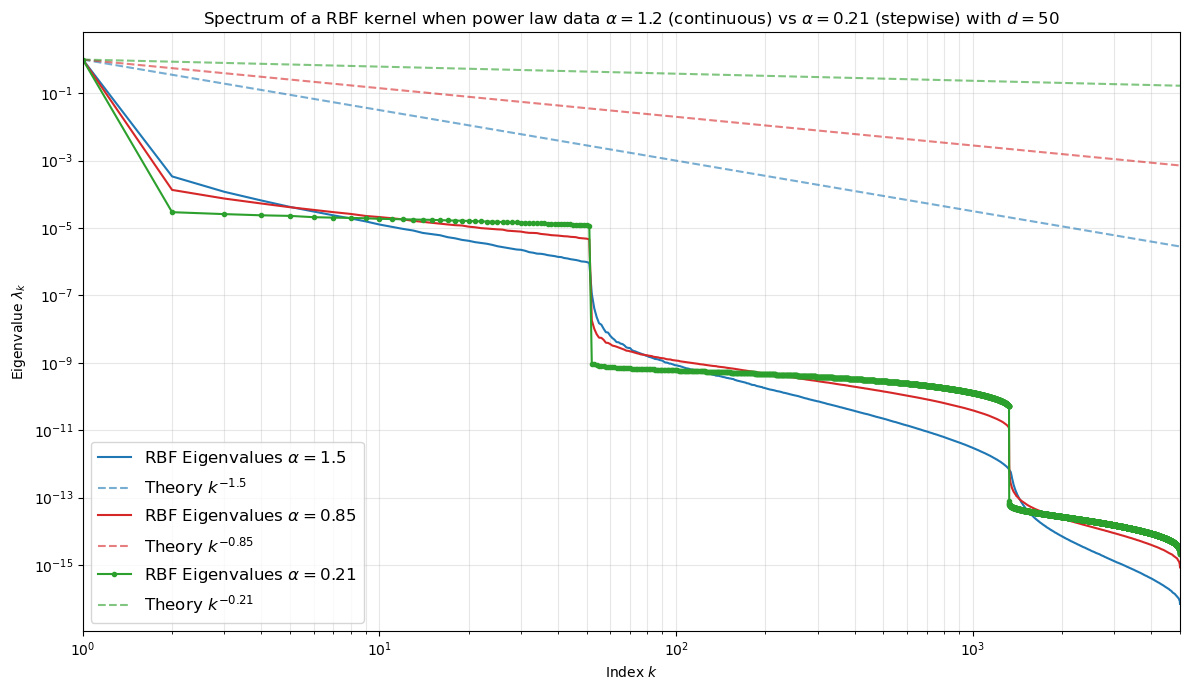

In [47]:

# --- PARAMETRI FISSI ---
d = 50
M = 5000
alphas = [1.5, 0.85, 0.21] # Lista degli alpha da testare

# Assumiamo che empiricalDiagonalization sia definita come nei messaggi precedenti
# (Se non lo è, incollala qui)

def rbf_kernel_matrix(X, gamma=1./d):
    # Calcolo ottimizzato distanze
    sq_norms = np.sum(X**2, axis=1)
    dist_sq = sq_norms[:, None] + sq_norms[None, :] - 2 * np.dot(X, X.T)
    dist_sq = np.maximum(dist_sq, 0.0)
    K = np.exp(-gamma * dist_sq)
    return K

plt.figure(figsize=(12, 7), dpi=100)

colors = ['#1f77b4', '#d62728', '#2ca02c'] # Blu, Rosso e Verde

for i, alpha in enumerate(alphas):
    # 1. Generazione Sigma
    Sigma_vals = np.array([k**(-alpha) for k in range(1, d+1)])
    
    # --- CORREZIONE MATEMATICA IMPORTANTE ---
    # Normalizziamo la traccia a 'd' affinché gamma=1/d abbia senso fisico
    Sigma_vals = Sigma_vals / np.sum(Sigma_vals) 
    Sigma = np.diag(Sigma_vals)
    Sigma = Sigma / d
    
    # 2. Diagonalizzazione
    # Nota: rbf_kernel_matrix usa di default gamma=1/d
    eigen_rbf = empiricalDiagonalization(M, rbf_kernel_matrix, Sigma)
    
    # 3. PLOT DATI EMPIRICI (Correzione Logica: plottiamo subito dentro il loop)
    plt.loglog(np.arange(1, M+1), eigen_rbf, 
               color=colors[i], 
               marker='o' if alpha < 0.5 else '', # Pallini solo per i gradini
               markersize=3,
               linewidth=1.5,
               label=fr'RBF Eigenvalues $\alpha={alpha}$')
    
    # 4. PLOT RIFERIMENTO POWER LAW
    # Trucco estetico: ancoriamo la retta teorica al primo autovalore empirico
    ref_x = np.arange(1, M+1)
    ref_y = ref_x**(-alpha)
    ref_y = ref_y * (eigen_rbf[0] / ref_y[0]) # Scaling per sovrapporre
    
    plt.loglog(ref_x, ref_y, 
               color=colors[i], 
               linestyle='--', 
               alpha=0.6,
               label=fr'Theory $k^{{-{alpha}}}$')

# Titoli e decorazioni
plt.xlabel('Index $k$')
plt.ylabel('Eigenvalue $\lambda_k$')
plt.xlim(1, M)
# Un po' di zoom sull'asse Y per non vedere il rumore di fondo macchina

plt.title(fr"Spectrum of a RBF kernel when power law data $\alpha=1.2$ (continuous) vs $\alpha=0.21$ (stepwise) with $d={d}$")
plt.legend(fontsize=12)
plt.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.show()